# **Connect to Dataset Kaggle**

In [ ]:
!python3 -m pip install --upgrade pip
!pip install kaggle

import json
import os

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# Replace "DATASET_NAME" and "DATASET_PATH" with the actual name and path of the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100%|█████████████████████████████████████▉| 5.20G/5.20G [02:40<00:00, 39.4MB/s]
100%|██████████████████████████████████████| 5.20G/5.20G [02:41<00:00, 34.7MB/s]


In [3]:
# Replace "DATASET_FILE" with the actual name of the dataset file
!unzip skin-cancer-mnist-ham10000.zip -d /workspace

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024306.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024307.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024308.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024309.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024310.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024311.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024312.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024313.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024314.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024315.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024316.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024317.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024318.jpg  
  inflating: /workspace/HAM10000_images_part_1/ISIC_0024319.jpg  
  inflating: /workspace/HAM10000_im

# **Create the Directory Structure**

In [ ]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install scipy
!pip install tensorflow

import pandas as pd
import numpy as np
import shutil
import tensorflow
import scipy

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image

import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 133.2 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 88.0 MB/s eta 0:00:00


In [ ]:
# Define the directory names
class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
split_names = ['train_dir', 'val_dir', 'test_dir']

base_dir = 'base_dir'
os.mkdir(base_dir)

#Create a directories for data splitting
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

#test_dir
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# Create sub-directories for each class
for split_name in split_names:
    for class_name in class_names:
        class_dir = os.path.join(base_dir, split_name, class_name)
        os.mkdir(class_dir)

In [ ]:
#create variable containing train and val data
df_data = pd.read_csv('/workspace/HAM10000_metadata.csv')

# **Create Stratified Val Set**

In [ ]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

In [ ]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(unique_id):

    unique_list = list(df['lesion_id'])

    if unique_id in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

In [ ]:
df_data['duplicates'].value_counts()

In [ ]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

# **Devide a Train, Validation, and Test Data**

In [ ]:
# Create a validation set (df_val) using a stratified split based on the 'dx' column
y = df['dx']
df_train, df_val_and_test = train_test_split(df, test_size=0.36, random_state=101, stratify=y)

# Split the combined validation+test set into validation and test sets
df_val, df_test = train_test_split(df_val_and_test, test_size=0.5, random_state=101, stratify=df_val_and_test['dx'])

# Define a function to identify if an image is part of the train, validation, or test set
def identify_train_val_or_test_rows(x):
    val_list = list(df_val['image_id'])
    test_list = list(df_test['image_id'])
    if str(x) in val_list:
        return 'val'
    elif str(x) in test_list:
        return 'test'
    else:
        return 'train'

# Create a new column 'train_val_or_test' in df_data and apply the identify_val_or_test_rows function
df_data['train_val_or_test'] = df_data['image_id']
df_data['train_val_or_test'] = df_data['train_val_or_test'].apply(identify_train_val_or_test_rows)

# Filter out rows to create the train set (df_train), validation set (df_val), and test set (df_test)
df_train = df_data[df_data['train_val_or_test'] == 'train']
df_val = df_data[df_data['train_val_or_test'] == 'val']
df_test = df_data[df_data['train_val_or_test'] == 'test']

# Print the lengths of the train, validation, and test sets
print(len(df_train))
print(len(df_val))
print(len(df_test))

In [ ]:
df_train['dx'].value_counts()

In [ ]:
df_val['dx'].value_counts()

In [ ]:
df_test['dx'].value_counts()

# **Transfer Images into Folders**

In [ ]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('/workspace/ham10000_images_part_1')
folder_2 = os.listdir('/workspace/ham10000_images_part_2')

# Get a list of train, val, and test images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])

In [ ]:
def transfer_images(image_list, split_dir):
    for image in image_list:
        fname = image + '.jpg'
        label = df_data.loc[image, 'dx']

        if fname in folder_1:
            src = os.path.join('/workspace/ham10000_images_part_1', fname)
            dst = os.path.join(split_dir, label, fname)
            shutil.copyfile(src, dst)

        if fname in folder_2:
            src = os.path.join('/workspace/ham10000_images_part_2', fname)
            dst = os.path.join(split_dir, label, fname)
            shutil.copyfile(src, dst)

transfer_images(train_list, train_dir)
transfer_images(val_list, val_dir)
transfer_images(test_list, test_dir)

# **Augment Imbalanced Data**

In [18]:
# List of classes and other parameters
# note that we are not augmenting class 'nv'

class_list = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
base_dir = 'base_dir'
num_aug_images_wanted = 5000
batch_size = 50

def augment_images(class_list, base_dir, num_aug_images_wanted, batch_size):
    # Create an image data generator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    # Loop through each class for augmentation
    for img_class in class_list:
        # Create a temporary directory for image manipulation
        img_dir = os.path.join('aug_dir', 'img_dir')
        os.makedirs(img_dir, exist_ok=True)

        # Copy original images to the temporary directory
        src_dir = os.path.join(base_dir, 'train_dir', img_class)
        img_list = os.listdir(src_dir)
        for fname in img_list:
            shutil.copyfile(os.path.join(src_dir, fname), os.path.join(img_dir, fname))

        # Set the destination path for augmented images
        save_path = os.path.join(base_dir, 'train_dir', img_class)

        # Create a data generator for augmented images
        aug_datagen = datagen.flow_from_directory(
            'aug_dir',
            save_to_dir=save_path,
            save_format='jpg',
            target_size=(224, 224),
            batch_size=batch_size)

        # Calculate the number of batches needed for desired augmentation
        num_files = len(os.listdir(img_dir))
        num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

        # Generate augmented images and add them to the training set
        for _ in range(num_batches):
            imgs, labels = next(aug_datagen)

        # Clean up the temporary directory
        shutil.rmtree('aug_dir')

# Call the augmentation function
augment_images(class_list, base_dir, num_aug_images_wanted, batch_size)

Found 451 images belonging to 1 classes.
Found 273 images belonging to 1 classes.
Found 119 images belonging to 1 classes.
Found 101 images belonging to 1 classes.


In [19]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5115
4970
5000
4560
4618
4027
3433


# **Set Up Generators**

In [20]:
train_path = 'base_dir/train_dir'
val_path = 'base_dir/val_dir'
test_path = 'base_dir/test_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
batch_size = 64
image_size = 224

train_steps = np.ceil(num_train_samples / batch_size)
val_steps = np.ceil(num_val_samples / batch_size)

In [21]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.xception.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size)

val_batches = datagen.flow_from_directory(val_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size)


test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 31723 images belonging to 7 classes.
Found 993 images belonging to 7 classes.
Found 993 images belonging to 7 classes.


# **Modify Model**

In [ ]:
import tensorflow.keras.applications as keras_ptm

M = keras_ptm.mobilenet_v2.MobileNetV2
R = keras_ptm.resnet_v2.ResNet50V2
D = keras_ptm.densenet.DenseNet121
I = keras_ptm.inception_v3.InceptionV3
X = keras_ptm.xception.Xception

# create a copy of a Xception
base_model = X(include_top=False, input_shape=(224,224,3))

In [70]:
len(base_model.layers)

132

In [71]:
# CREATE THE MODEL ARCHITECTURE

# Create a new dense layer for predictions
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# add a fully connected layer and dropout
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

In [72]:
for layer in base_model.layers:
    layer.trainable=False

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

# **Train Model**

In [73]:
initial_lr=0.001

loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits = False,
                               name='categorical_crossentropy' )

model.compile(Adam(learning_rate=initial_lr), loss=loss,
              metrics=[categorical_accuracy])

In [74]:
filepath = "best_model.h5"

# Define a simple earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

# Save the best model
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
adaptive_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                              verbose=1, mode='min', min_lr=0.00001)

callbacks_list = [earlystop, checkpoint, adaptive_lr]

history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    validation_data=val_batches,
                    validation_steps=val_steps,
                    epochs=15, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/15
126/126 [==============================] - ETA: 0s - loss: 1.7696 - categorical_accuracy: 0.4497
Epoch 1: val_categorical_accuracy improved from -inf to 0.76032, saving model to best_xception.h5
126/126 [==============================] - 27s 196ms/step - loss: 1.7696 - categorical_accuracy: 0.4497 - val_loss: 0.9544 - val_categorical_accuracy: 0.7603 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - ETA: 0s - loss: 1.3717 - categorical_accuracy: 0.5330
Epoch 2: val_categorical_accuracy improved from 0.76032 to 0.79053, saving model to best_xception.h5
126/126 [==============================] - 26s 209ms/step - loss: 1.3717 - categorical_accuracy: 0.5330 - val_loss: 0.7209 - val_categorical_accuracy: 0.7905 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - ETA: 0s - loss: 1.2061 - categorical_accuracy: 0.5727
Epoch 3: val_categorical_accuracy improved from 0.79053 to 0.83787, saving model to best_xception.h5
126/126 [=========================

# **Evaluate the Model**

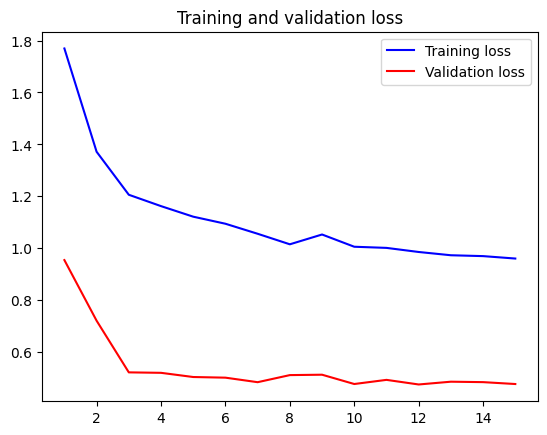

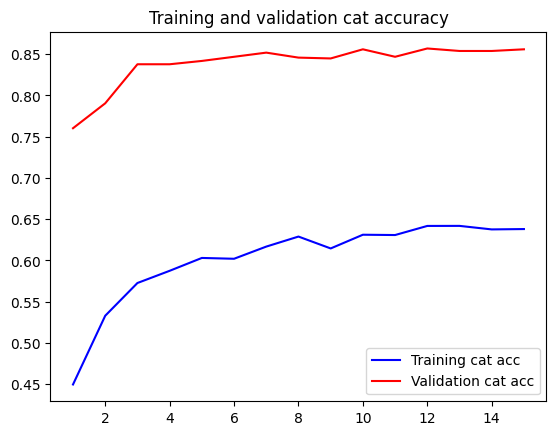

<Figure size 640x480 with 0 Axes>

In [75]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'b', label='Training cat acc')
plt.plot(epochs, val_acc, 'r', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.show()

In [76]:
test_score = model.evaluate(test_batches)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

993/993 [==============================] - 8s 8ms/step - loss: 0.4790 - categorical_accuracy: 0.8419
[INFO] accuracy: 84.19%
[INFO] Loss:  0.4790436029434204


993/993 [==============================] - 8s 7ms/step
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       akiec       0.44      0.41      0.42        27
         bcc       0.50      0.45      0.47        31
         bkl       0.50      0.42      0.46        80
          df       0.67      0.29      0.40         7
         mel       0.33      0.27      0.30        41
          nv       0.92      0.95      0.93       795
        vasc       0.75      0.50      0.60        12

    accuracy                           0.84       993
   macro avg       0.59      0.47      0.51       993
weighted avg       0.83      0.84      0.83       993



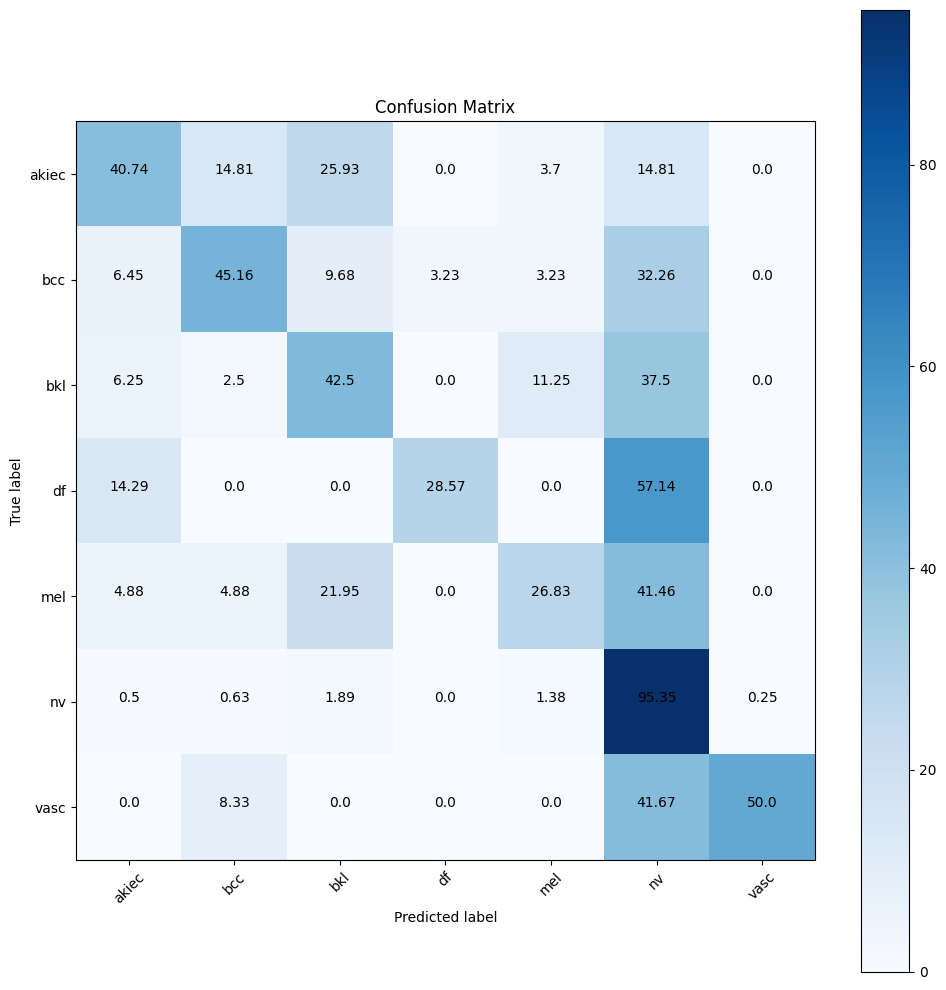

In [77]:
class_names = []
for key in train_batches.class_indices:
    class_names.append(key)

#Plot the confusion matrix.

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black")

#Confution Matrix

Y_pred = model.predict(test_batches)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_batches.classes
print('Confusion Matrix')

cm = confusion_matrix(y_true, y_pred)
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
cm = np.around(cm_perc, decimals=2)
cm[np.isnan(cm)] = 0.0


plot_confusion_matrix(cm, class_names, title='Confusion Matrix')


#Print Classification Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_names))

# **Fine Tune The Model**

In [88]:
model.load_weights("best_model.h5")

for layer in base_model.layers:
   layer.trainable = True

In [89]:
fine_tune_lr=0.001

loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits = False,
                               name='categorical_crossentropy' )

model.compile(Adam(learning_rate=fine_tune_lr), loss=loss,
              metrics=[categorical_accuracy])

In [90]:
filepath = "best_model_tuned.h5"

# Define a simple earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)

# Save the best model
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
adaptive_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1,
                              verbose=1, mode='min', min_lr=0.00001)

callbacks_list = [earlystop, checkpoint, adaptive_lr]

retrain_history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    validation_data=val_batches,
                    validation_steps=val_steps,
                    epochs=15, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/15
126/126 [==============================] - ETA: 0s - loss: 0.9031 - categorical_accuracy: 0.6708
Epoch 1: val_categorical_accuracy improved from -inf to 0.76636, saving model to best_xception_tuned.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


126/126 [==============================] - 69s 411ms/step - loss: 0.9031 - categorical_accuracy: 0.6708 - val_loss: 0.7867 - val_categorical_accuracy: 0.7664 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - ETA: 0s - loss: 0.5586 - categorical_accuracy: 0.7969
Epoch 2: val_categorical_accuracy improved from 0.76636 to 0.80463, saving model to best_xception_tuned.h5
126/126 [==============================] - 55s 439ms/step - loss: 0.5586 - categorical_accuracy: 0.7969 - val_loss: 0.7706 - val_categorical_accuracy: 0.8046 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - ETA: 0s - loss: 0.4511 - categorical_accuracy: 0.8383
Epoch 3: val_categorical_accuracy improved from 0.80463 to 0.87110, saving model to best_xception_tuned.h5
126/126 [==============================] - 57s 451ms/step - loss: 0.4511 - categorical_accuracy: 0.8383 - val_loss: 0.4006 - val_categorical_accuracy: 0.8711 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - ETA

# **Evaluate the Model**

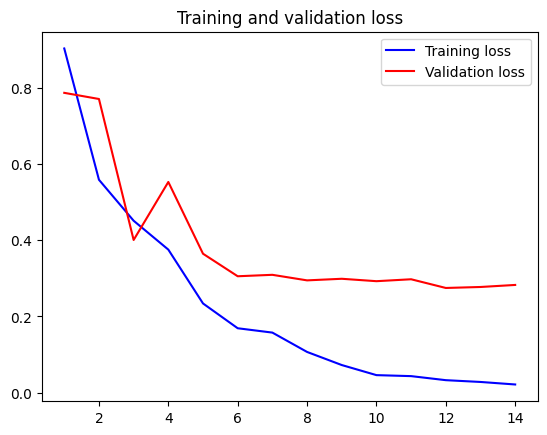

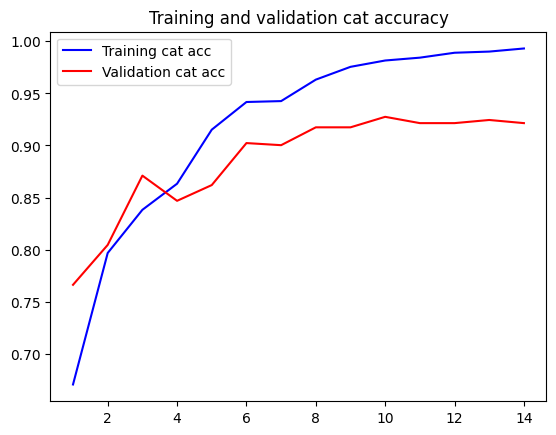

<Figure size 640x480 with 0 Axes>

In [91]:
acc = retrain_history.history['categorical_accuracy']
val_acc = retrain_history.history['val_categorical_accuracy']
loss = retrain_history.history['loss']
val_loss = retrain_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'b', label='Training cat acc')
plt.plot(epochs, val_acc, 'r', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.show()

In [92]:
test_score = model.evaluate(test_batches)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

993/993 [==============================] - 7s 7ms/step - loss: 0.2780 - categorical_accuracy: 0.9285
[INFO] accuracy: 92.85%
[INFO] Loss:  0.27795758843421936


993/993 [==============================] - 8s 8ms/step
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       akiec       0.82      0.67      0.73        27
         bcc       0.83      0.81      0.82        31
         bkl       0.81      0.75      0.78        80
          df       1.00      0.71      0.83         7
         mel       0.61      0.68      0.64        41
          nv       0.96      0.98      0.97       795
        vasc       1.00      0.67      0.80        12

    accuracy                           0.93       993
   macro avg       0.86      0.75      0.80       993
weighted avg       0.93      0.93      0.93       993



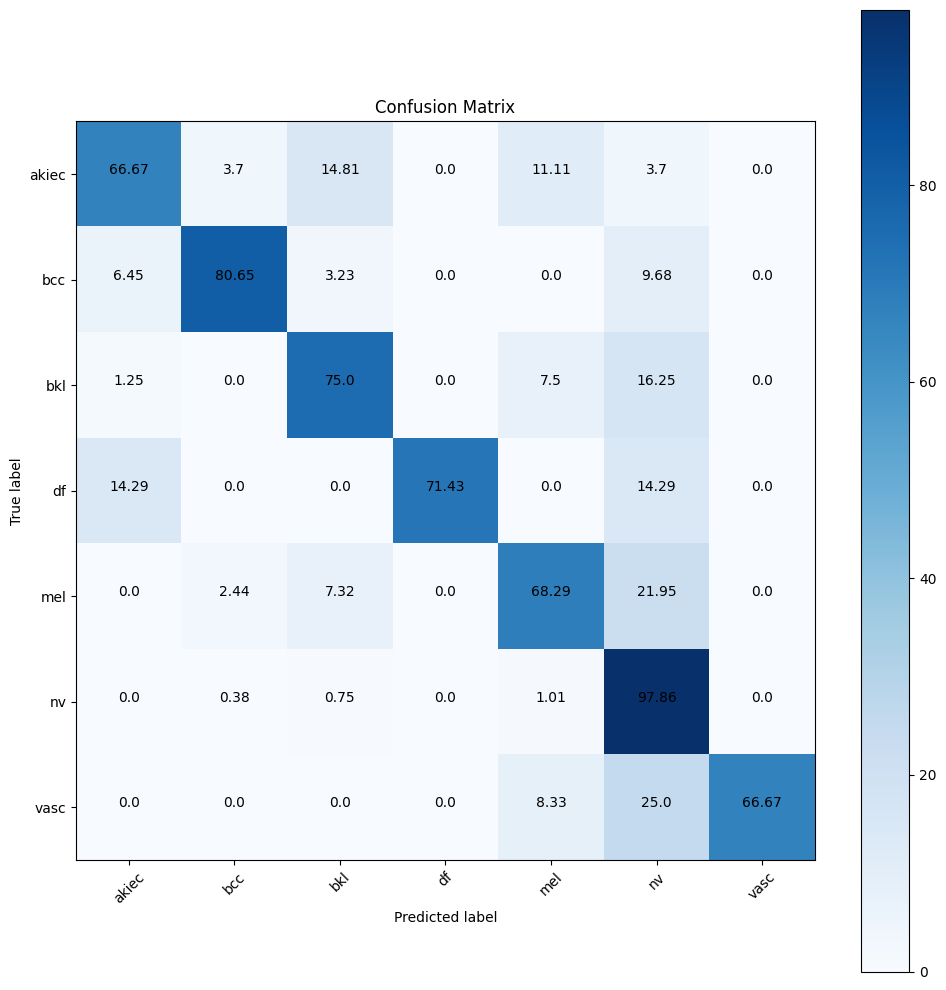

In [94]:
class_names = []
for key in train_batches.class_indices:
    class_names.append(key)

#Plot the confusion matrix.

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black")

#Confution Matrix

Y_pred = model.predict(test_batches)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_batches.classes
print('Confusion Matrix')

cm = confusion_matrix(y_true, y_pred)
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
cm = np.around(cm_perc, decimals=2)
cm[np.isnan(cm)] = 0.0


plot_confusion_matrix(cm, class_names, title='Confusion Matrix')


#Print Classification Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_names))

# **Predictions**

In [95]:
# Load the best model saved during training
best_model = tensorflow.keras.models.load_model('best_xception_tuned.h5')

# Make predictions on the test data
predictions = best_model.predict(test_batches, verbose=1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)

# Get the true class labels from the test batches generator
true_labels = test_batches.classes

993/993 [==============================] - 8s 8ms/step


In [96]:
# Convert predicted and true numeric labels to class names
predicted_class_names = [class_names[label] for label in predicted_labels]
true_class_names = [class_names[label] for label in true_labels]

# Get the list of filenames in the same order as the predictions
file_names = test_batches.filenames

# Print or analyze the results
for i in range(len(file_names)):
    print(f"File: {file_names[i]}, True Class: {true_class_names[i]}, Predicted Class: {predicted_class_names[i]}")

File: akiec/ISIC_0024329.jpg, True Class: akiec, Predicted Class: akiec
File: akiec/ISIC_0024511.jpg, True Class: akiec, Predicted Class: bkl
File: akiec/ISIC_0025264.jpg, True Class: akiec, Predicted Class: mel
File: akiec/ISIC_0025368.jpg, True Class: akiec, Predicted Class: akiec
File: akiec/ISIC_0025637.jpg, True Class: akiec, Predicted Class: akiec
File: akiec/ISIC_0025712.jpg, True Class: akiec, Predicted Class: akiec
File: akiec/ISIC_0025803.jpg, True Class: akiec, Predicted Class: bkl
File: akiec/ISIC_0025948.jpg, True Class: akiec, Predicted Class: bkl
File: akiec/ISIC_0026132.jpg, True Class: akiec, Predicted Class: akiec
File: akiec/ISIC_0026212.jpg, True Class: akiec, Predicted Class: bkl
File: akiec/ISIC_0027172.jpg, True Class: akiec, Predicted Class: akiec
File: akiec/ISIC_0028190.jpg, True Class: akiec, Predicted Class: akiec
File: akiec/ISIC_0028763.jpg, True Class: akiec, Predicted Class: akiec
File: akiec/ISIC_0029133.jpg, True Class: akiec, Predicted Class: akiec
Fi

# **Export Model**

In [86]:
model.save('model_skin.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
# Load the model from the file
model = tensorflow.keras.models.load_model('model_skin.h5')

# Convert the model to the TensorFlow Lite format
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a file
open("converted_model.tflite", "wb").write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpopodpj0l/assets


INFO:tensorflow:Assets written to: /tmp/tmpopodpj0l/assets
2024-06-26 14:17:50.482324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-26 14:17:50.482368: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-26 14:17:50.482637: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpopodpj0l
2024-06-26 14:17:50.515054: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-26 14:17:50.515094: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpopodpj0l
2024-06-26 14:17:50.604802: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-26 14:17:51.619018: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpopodpj0l
2024-06-26 14:17:51.890328: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

83230608